In [1]:
import boto3
import configparser
import os
import urllib3

import folium
import geopandas as gpd
import rasterio
from rasterio.plot import show
import numpy as np
from matplotlib import pyplot

import tempfile

In [2]:
urllib3.disable_warnings()

### Connection with S3 Bucket
All Census GRID datasets are available on S3 Bucket. Below configuration allows to list and download defined datasets from there.

In [3]:
def s3_connection(credentials: dict) -> boto3.session.Session:
    """Establishes a connection to an S3 bucket.

    Args:
        credentials (dict): A dictionary containing AWS S3 credentials with keys 
                            'host_base', 'access_key', and 'secret_key'.

    Returns:
        boto3.session.Session: A boto3 session client configured with the provided 
                               credentials for interacting with the S3 service.
    """
    s3 = boto3.client('s3',
                      endpoint_url=credentials['host_base'],
                      aws_access_key_id=credentials['access_key'],
                      aws_secret_access_key=credentials['secret_key'],
                      use_ssl=True,
                      verify=False)
    return s3

# Load s3 credentials
config = configparser.ConfigParser()
config.read('/home/eouser/.s3cfg')
credentials = dict(config['default'].items())

# Connection with S3 eodata
s3 = s3_connection(credentials)

### Browsing S3 bucket content

In [4]:
response = s3.list_objects_v2(Bucket='ESTAT', Prefix='Census_GRID')

In [5]:
if 'Contents' in response:
    print("Objects in bucket:")
    # Iterate over each object
    for obj in response['Contents']:
        print(obj['Key'])
else:
    print("No objects found in the bucket.")

Objects in bucket:
Census_GRID/2021/ESTAT_Census_2021_V2.csv
Census_GRID/2021/ESTAT_Census_2021_V2.gpkg
Census_GRID/2021/ESTAT_Census_2021_V2.parquet
Census_GRID/2021/ESTAT_Census_2021_V2_SDMX_Metadata/CENSUS_INS21ES_A_AT_2021_0000.sdmx.xml
Census_GRID/2021/ESTAT_Census_2021_V2_SDMX_Metadata/CENSUS_INS21ES_A_BE_2021_0000.sdmx.xml
Census_GRID/2021/ESTAT_Census_2021_V2_SDMX_Metadata/CENSUS_INS21ES_A_BG_2021_0000.sdmx.xml
Census_GRID/2021/ESTAT_Census_2021_V2_SDMX_Metadata/CENSUS_INS21ES_A_CH_2021_0000.sdmx.xml
Census_GRID/2021/ESTAT_Census_2021_V2_SDMX_Metadata/CENSUS_INS21ES_A_CY_2021_0000.sdmx.xml
Census_GRID/2021/ESTAT_Census_2021_V2_SDMX_Metadata/CENSUS_INS21ES_A_CZ_2021_0000.sdmx.xml
Census_GRID/2021/ESTAT_Census_2021_V2_SDMX_Metadata/CENSUS_INS21ES_A_DE_2021_0000.sdmx.xml
Census_GRID/2021/ESTAT_Census_2021_V2_SDMX_Metadata/CENSUS_INS21ES_A_DK_2021_0000.sdmx.xml
Census_GRID/2021/ESTAT_Census_2021_V2_SDMX_Metadata/CENSUS_INS21ES_A_EE_2021_0000.sdmx.xml
Census_GRID/2021/ESTAT_Census_2

### Reading vector file to GeoDataFrame

In [6]:
%%time 

object_path = 'Census_GRID/2021/ESTAT_Census_2021_V2.gpkg'

# Create a temporary directory to store GeoPackage file
with tempfile.TemporaryDirectory() as tmpdirname:
    # Define local path to save GeoPackage file
    local_geopackage_path = os.path.join(tmpdirname, object_path.split('/')[-1])

    # Download the GeoPackage from S3
    s3.download_file('ESTAT', object_path, local_geopackage_path)

    # Read the GeoPackage into a GeoDataFrame
    gdf = gpd.read_file(local_geopackage_path)

CPU times: user 1min 8s, sys: 4.87 s, total: 1min 13s
Wall time: 1min 11s


In [7]:
# Geodata parameters
print(gdf.info())
print('----')
print(f'Coordinate system: {gdf.crs}')

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 4594018 entries, 0 to 4594017
Data columns (total 18 columns):
 #   Column              Dtype   
---  ------              -----   
 0   GRD_ID              object  
 1   T                   int64   
 2   M                   float64 
 3   F                   float64 
 4   Y_LT15              float64 
 5   Y_1564              float64 
 6   Y_GE65              float64 
 7   EMP                 float64 
 8   NAT                 float64 
 9   EU_OTH              float64 
 10  OTH                 float64 
 11  SAME                float64 
 12  CHG_IN              float64 
 13  CHG_OUT             float64 
 14  LAND_SURFACE        float64 
 15  POPULATED           int64   
 16  CONFIDENTIALSTATUS  float64 
 17  geometry            geometry
dtypes: float64(14), geometry(1), int64(2), object(1)
memory usage: 630.9+ MB
None
----
Coordinate system: EPSG:3035


In [8]:
gdf.head()

,GRD_ID,T,M,F,Y_LT15,Y_1564,Y_GE65,EMP,NAT,EU_OTH,OTH,SAME,CHG_IN,CHG_OUT,LAND_SURFACE,POPULATED,CONFIDENTIALSTATUS,geometry
0,CRS3035RES1000mN1000000E1966000,259,143.0,116.0,38.0,190.0,29.0,86.0,113.0,94.0,47.0,220.0,24.0,11.0,0.6115,1,NaN,"POLYGON ((1966000 1000000, 1967000 1000000, 19..."
1,CRS3035RES1000mN1000000E1967000,4,4.0,2.0,1.0,2.0,2.0,2.0,4.0,0.0,0.0,4.0,0.0,0.0,1.0000,1,NaN,"POLYGON ((1967000 1000000, 1968000 1000000, 19..."
2,CRS3035RES1000mN1000000E1968000,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0000,0,NaN,"POLYGON ((1968000 1000000, 1969000 1000000, 19..."
3,CRS3035RES1000mN1000000E1969000,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0000,0,NaN,"POLYGON ((1969000 1000000, 1970000 1000000, 19..."
4,CRS3035RES1000mN1000000E1970000,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0000,0,NaN,"POLYGON ((1970000 1000000, 1971000 1000000, 19..."


### GeoDataFrame explanation

GeoDataFrame inherits most of pandas DataFrame methods. That allows to work with GeoDataFrame on the same way. 

In [9]:
# Creating new GeoDataFrame with defined columns
gdf[['GRD_ID','POPULATED','geometry']]

,GRD_ID,POPULATED,geometry
0,CRS3035RES1000mN1000000E1966000,1,"POLYGON ((1966000 1000000, 1967000 1000000, 19..."
1,CRS3035RES1000mN1000000E1967000,1,"POLYGON ((1967000 1000000, 1968000 1000000, 19..."
2,CRS3035RES1000mN1000000E1968000,0,"POLYGON ((1968000 1000000, 1969000 1000000, 19..."
3,CRS3035RES1000mN1000000E1969000,0,"POLYGON ((1969000 1000000, 1970000 1000000, 19..."
4,CRS3035RES1000mN1000000E1970000,0,"POLYGON ((1970000 1000000, 1971000 1000000, 19..."
...,...,...,...
4594013,CRS3035RES1000mN999000E1981000,1,"POLYGON ((1981000 999000, 1982000 999000, 1982..."
4594014,CRS3035RES1000mN999000E1982000,1,"POLYGON ((1982000 999000, 1983000 999000, 1983..."
4594015,CRS3035RES1000mN999000E1983000,0,"POLYGON ((1983000 999000, 1984000 999000, 1984..."
4594016,CRS3035RES1000mN999000E1985000,0,"POLYGON ((1985000 999000, 1986000 999000, 1986..."


In [10]:
# Filtering records based on attribute value 
gdf[gdf['T']>20].head()

,GRD_ID,T,M,F,Y_LT15,Y_1564,Y_GE65,EMP,NAT,EU_OTH,OTH,SAME,CHG_IN,CHG_OUT,LAND_SURFACE,POPULATED,CONFIDENTIALSTATUS,geometry
0,CRS3035RES1000mN1000000E1966000,259,143.0,116.0,38.0,190.0,29.0,86.0,113.0,94.0,47.0,220.0,24.0,11.0,0.6115,1,NaN,"POLYGON ((1966000 1000000, 1967000 1000000, 19..."
14,CRS3035RES1000mN1000000E1980000,285,143.0,142.0,38.0,215.0,29.0,92.0,152.0,50.0,85.0,234.0,46.0,5.0,1.0000,1,NaN,"POLYGON ((1980000 1000000, 1981000 1000000, 19..."
15,CRS3035RES1000mN1000000E1981000,1828,973.0,856.0,198.0,1377.0,254.0,606.0,819.0,494.0,513.0,1465.0,267.0,90.0,0.6775,1,NaN,"POLYGON ((1981000 1000000, 1982000 1000000, 19..."
16,CRS3035RES1000mN1000000E1982000,139,74.0,65.0,24.0,95.0,21.0,34.0,53.0,58.0,29.0,104.0,27.0,8.0,0.0504,1,NaN,"POLYGON ((1982000 1000000, 1983000 1000000, 19..."
35,CRS3035RES1000mN1001000E1981000,7716,4028.0,3689.0,1062.0,5902.0,754.0,2659.0,3665.0,1440.0,2615.0,6281.0,1152.0,224.0,0.7921,1,NaN,"POLYGON ((1981000 1001000, 1982000 1001000, 19..."


### Displaying geometries on basemap

To display vector geometry on map we recommend folium. Folium allows displaying different types of geometries like Polygons, Lines and Points. <br>
IMPORTANT: Each geometry presenting on map must be transformed to EPSG:4326 coordinates system

In [11]:
# Filtering many polygons
gdf_filter = gdf.loc[:100]

In [12]:
# Add the polygons to the map

m1 = folium.Map(location=[28.730442, -13.911504], zoom_start=13)

for _, r in gdf_filter.to_crs(4326).iterrows():
    sim_geo = gpd.GeoSeries(r["geometry"]).simplify(tolerance=0.001)
    geo_j = sim_geo.to_json()
    geo_j = folium.GeoJson(data=geo_j, style_function=lambda x: {"fillColor": "orange"})
    folium.Popup(r["GRD_ID"]).add_to(geo_j)
    geo_j.add_to(m1)

m1

### Reading raster file
Geographic information systems use GeoTIFF and other formats to organize and store gridded, or raster, datasets. Rasterio reads and writes these formats and provides a Python API based on N-D arrays. <br>
More information: https://rasterio.readthedocs.io/en/stable/quickstart.html

In [13]:
# S3 reference to GeoTIFF
object_path = 'Census_GRID/2021/ESTAT_OBS-VALUE-POPULATED_2021_V2.tiff'

# Create a temporary directory to store the raster file
with tempfile.TemporaryDirectory() as tmpdirname:
    # Define local path to save raster file
    local_raster_path = os.path.join(tmpdirname, object_path.split('/')[-1])

    # Download raster from S3
    s3.download_file('ESTAT', object_path, local_raster_path)

    # Read raster into numpy array
    with rasterio.open(local_raster_path) as src:
        raster_data = src.read()
        raster_metadata = src.meta

In [14]:
# Printing metadata

print(src.meta) # Raster total metadata
print('---')
print(src.width, src.height) # Numner of rows and columns in raster
print(src.crs) # Coordinate system
print(src.transform) # Parameters of affine transformation
print(src.count) # Number of bands

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -1.0, 'width': 5562, 'height': 4475, 'count': 1, 'crs': CRS.from_wkt('PROJCS["ETRS89-extended / LAEA Europe",GEOGCS["ETRS89",DATUM["European_Terrestrial_Reference_System_1989",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6258"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4258"]],PROJECTION["Lambert_Azimuthal_Equal_Area"],PARAMETER["latitude_of_center",52],PARAMETER["longitude_of_center",10],PARAMETER["false_easting",4321000],PARAMETER["false_northing",3210000],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Northing",NORTH],AXIS["Easting",EAST],AUTHORITY["EPSG","3035"]]'), 'transform': Affine(1000.0, 0.0, 943000.0,
       0.0, -1000.0, 5416000.0)}
---
5562 4475
EPSG:3035
| 1000.00, 0.00, 943000.00|
| 0.00,-1000.00, 5416000.00|
| 0.00, 0.00, 1.00|
1


In [15]:
# Raster data is read as numpy array
print(type(raster_data))
print(raster_data.shape)
raster_data

<class 'numpy.ndarray'>
(1, 4475, 5562)


array([[[-1., -1., -1., ..., -1., -1., -1.],
        [-1., -1., -1., ..., -1., -1., -1.],
        [-1., -1., -1., ..., -1., -1., -1.],
        ...,
        [-1., -1., -1., ..., -1., -1., -1.],
        [-1., -1., -1., ..., -1., -1., -1.],
        [-1., -1., -1., ..., -1., -1., -1.]]], dtype=float32)

### Plotting raster file
There are couple of options to plot raster file. Below we present most popular option using matplotlib.pyplot module and tool implemented in rasterio package.
More information:
- https://matplotlib.org/3.5.3/api/_as_gen/matplotlib.pyplot.html
- https://rasterio.readthedocs.io/en/stable/topics/plotting.html

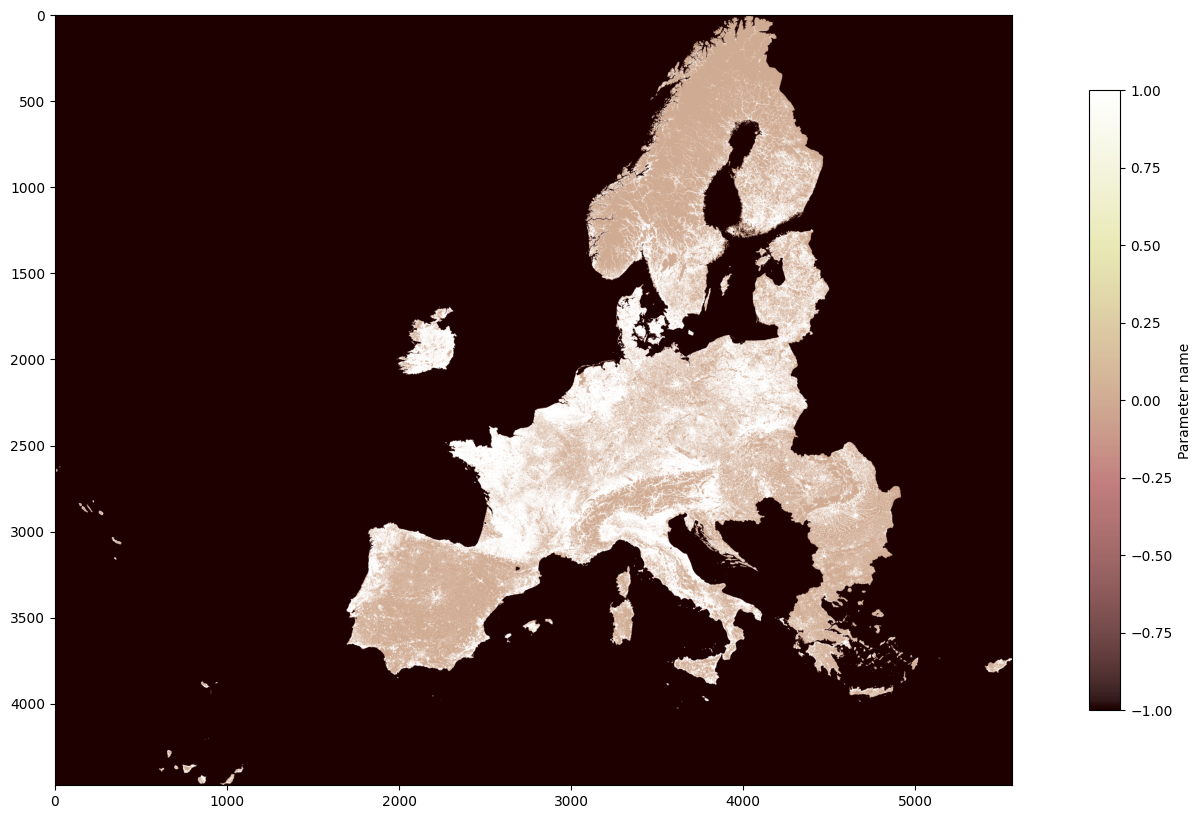

In [16]:
# Plotting definition
fig, ax = pyplot.subplots(1, figsize=(20,10))

# Plotting raster
pyplot.imshow(raster_data[0], cmap='pink')

# Plotting color bar
pyplot.colorbar(label='Parameter name', fraction=0.02, ax=ax)

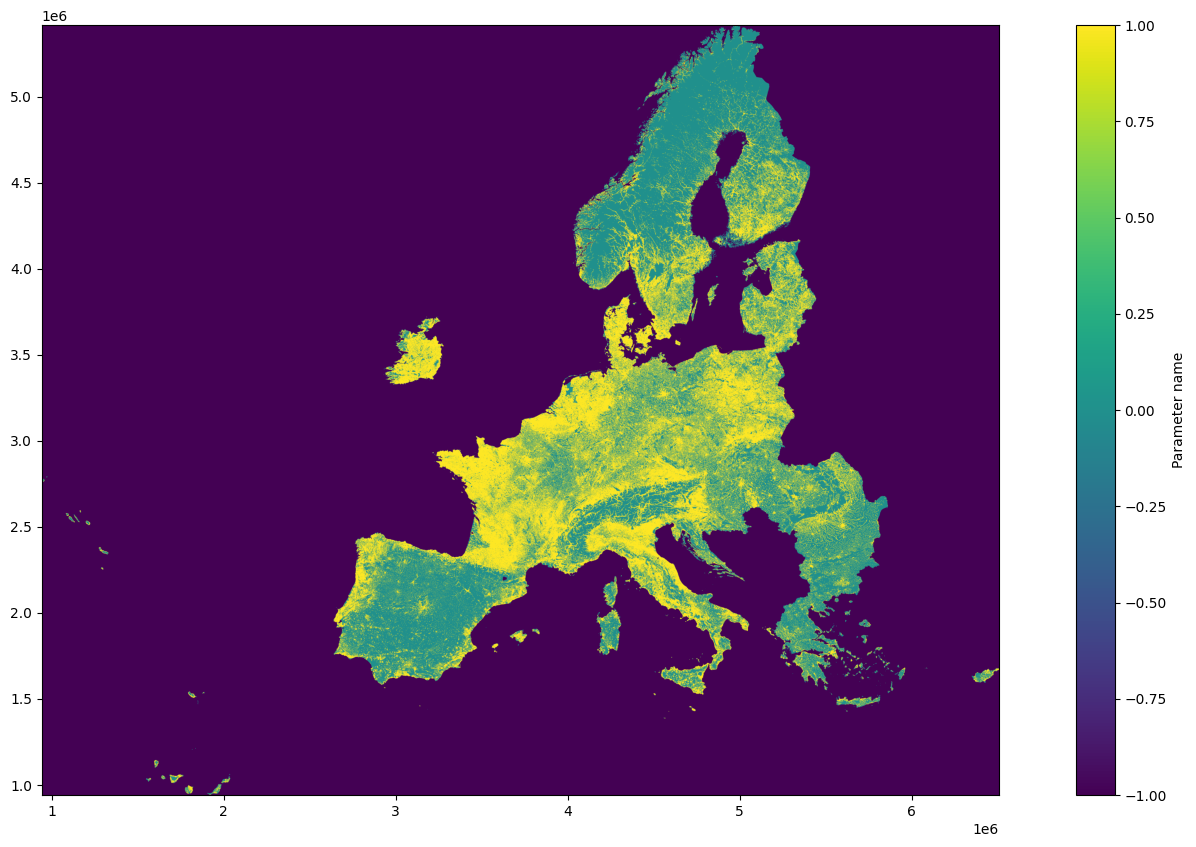

In [17]:
# Rasterio also provides rasterio.plot.show() to perform common tasks such as displaying 
# multi-band images as RGB and labeling the axes with proper geo-referenced extents.

# Plotting definition
fig, ax = pyplot.subplots(1, figsize=(20,10))

# Plotting raster with georeference
rs = show(raster_data[0], ax=ax, transform=src.transform)

# Plotting color bar
fig.colorbar(rs.get_images()[0], ax=ax, label='Parameter name')

### Reading Parquet file to GeoDataFrame

In [18]:
%%time

object_path = 'Census_GRID/2021/ESTAT_Census_2021_V2.parquet'

# Create a temporary directory to store parquet file
with tempfile.TemporaryDirectory() as tmpdirname:
    # Define local path to save parquet
    local_parquet_path = os.path.join(tmpdirname, object_path.split('/')[-1])

    # Download the parquet file from S3
    s3.download_file('ESTAT', object_path, local_parquet_path)

    # Read the parquet into a GeoDataFrame
    gdf = gpd.read_parquet(local_parquet_path)

CPU times: user 6.89 s, sys: 2.61 s, total: 9.51 s
Wall time: 6.51 s


In [19]:
gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 4594018 entries, 0 to 4594017
Data columns (total 18 columns):
 #   Column              Dtype   
---  ------              -----   
 0   GRD_ID              object  
 1   T                   int64   
 2   M                   float64 
 3   F                   float64 
 4   Y_LT15              float64 
 5   Y_1564              float64 
 6   Y_GE65              float64 
 7   EMP                 float64 
 8   NAT                 float64 
 9   EU_OTH              float64 
 10  OTH                 float64 
 11  SAME                float64 
 12  CHG_IN              float64 
 13  CHG_OUT             float64 
 14  LAND_SURFACE        float64 
 15  POPULATED           int64   
 16  CONFIDENTIALSTATUS  float64 
 17  geom                geometry
dtypes: float64(14), geometry(1), int64(2), object(1)
memory usage: 630.9+ MB
